In [47]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import datetime

# Loading data

In [3]:
weather_a = pd.read_csv('data/2149507.csv')
mobility = pd.read_csv('data/Global_Mobility_Report.csv', dtype = {'sub_region_1': str, 'sub_region_2': str})
china_mobility = pd.read_csv('data/China_(City Movement Intensity) 0101-0502.csv')
us_cases = pd.read_csv('data/US_covid_by_county.csv')
china_cases = pd.read_csv('data/China_covid_by_city.csv') 
decentralization = pd.read_excel('data/Kopie+von+Ivanyna+Shah+Decentralization+Dataset+Jan+2014.xls', 'Data')
mobilityus = pd.read_csv('data/mobilityus.csv')
covid_stringency = pd.read_csv('data/covid-stringency-index.csv')
county_pres = pd.read_csv('data/countypres_2000-2016.csv')

##  Centralized Dataframe

In [101]:
data = mobilityus.dropna().copy()
data.date = pd.to_datetime(data.date)
data['avg_mobility'] = data.filter(['retail', 'grocery', 'parks', 'transit', 'workplaces', 'residential']).mean(axis = 1)
data

,state,abbreviation,county,date,retail,grocery,parks,transit,workplaces,residential,stay_at_home,dem_share,income,pop,pct_pov,covid_cases,avg_mobility
101,Alabama,AL,Baldwin County,2020-02-15,17.0,12.0,55.0,8.0,6.0,-2.0,0,0.193856,57588.0,223234.0,9.8,0.0,16.000000
102,Alabama,AL,Baldwin County,2020-02-16,8.0,8.0,-12.0,7.0,-3.0,2.0,0,0.193856,57588.0,223234.0,9.8,0.0,1.666667
103,Alabama,AL,Baldwin County,2020-02-17,9.0,9.0,31.0,7.0,-3.0,1.0,0,0.193856,57588.0,223234.0,9.8,0.0,9.000000
104,Alabama,AL,Baldwin County,2020-02-18,7.0,8.0,21.0,0.0,2.0,0.0,0,0.193856,57588.0,223234.0,9.8,0.0,6.333333
105,Alabama,AL,Baldwin County,2020-02-19,12.0,9.0,41.0,8.0,3.0,-1.0,0,0.193856,57588.0,223234.0,9.8,0.0,12.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240092,Wyoming,WY,Natrona County,2020-05-15,-11.0,6.0,67.0,-16.0,-27.0,10.0,1,0.197223,64714.0,79858.0,9.9,39.0,4.833333
240096,Wyoming,WY,Natrona County,2020-05-19,2.0,10.0,93.0,-19.0,-25.0,8.0,1,0.197223,64714.0,79858.0,9.9,49.0,11.500000
240097,Wyoming,WY,Natrona County,2020-05-20,2.0,5.0,49.0,-19.0,-26.0,9.0,1,0.197223,64714.0,79858.0,9.9,64.0,3.333333
240098,Wyoming,WY,Natrona County,2020-05-21,1.0,12.0,48.0,-5.0,-27.0,8.0,1,0.197223,64714.0,79858.0,9.9,66.0,6.166667


## Plots
5 counties for average mobility across all sectors

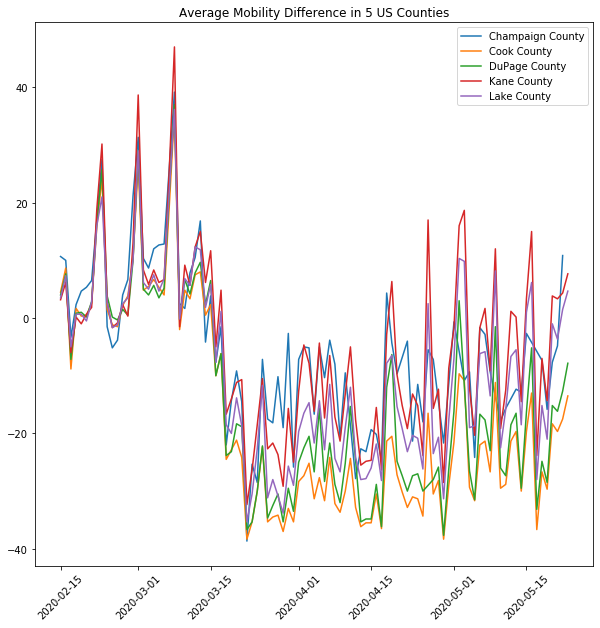

In [106]:
plt.figure(figsize = (10, 10))
state = data[data.state == 'Illinois']
for county in state.county.unique()[:5]:
    plt.plot(state[state.county == county].date, state[state.county == county].avg_mobility, label = county)
plt.xticks(rotation = 45)
plt.legend()
plt.title('Average Mobility Difference in 5 US Counties')
plt.show()

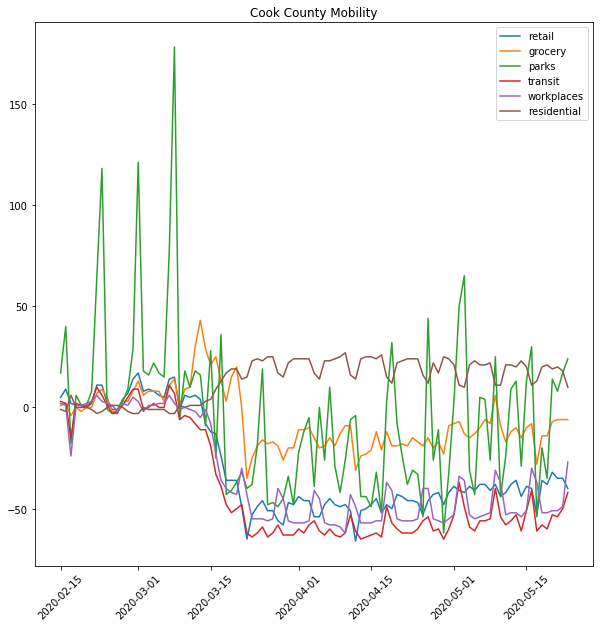

In [6]:
plt.figure(figsize = (10, 10))
state = data[data.state == 'Illinois']
for column in ['retail', 'grocery', 'parks', 'transit', 'workplaces', 'residential']:
    plt.plot(state[state.county == 'Cook County'].date, state[state.county == 'Cook County'][column], label = column)
plt.xticks(rotation = 45)
plt.title('Cook County Mobility')
plt.legend()
plt.show()

### China
#### compute baseline: the median value, for the corresponding day of the week, from Jan 1 - Jan-15


In [94]:
china = china_mobility.T.copy()
china.columns = china.iloc[0]
china = china[1:]
china.index = pd.to_datetime(china.index)
china = china.astype('float')
china = china.reset_index()
# find day of the week
china['weekday'] = china['index'].dt.dayofweek
temp = china[(china['index'] >= '2020-01-01') & (china['index'] <= '2020-01-15')]

baseline = temp.iloc[:, 1:].groupby('weekday').median()

# compute the percentage differences from the baseline
def compute_diff(row, baseline):
    day = row['weekday']
    return (row[1:-1] - baseline.loc[day, :]) * 100

modified_china = china.apply(lambda row: compute_diff(row, baseline), axis = 1)

modified_china['date'] = china['index']

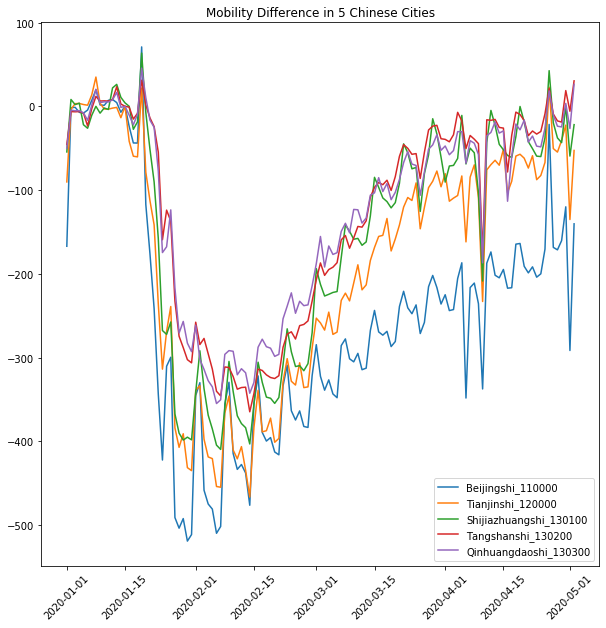

In [107]:
plt.figure(figsize = (10, 10))
for column in modified_china.columns[:5]:
    plt.plot(modified_china.date, modified_china[column], label = column)
plt.xticks(rotation = 45)
plt.title('Mobility Difference in 5 Chinese Cities')
plt.legend()
plt.show()

## Double LASSO - Feature Selection

In [32]:
def double_lasso(data, treatment, covariates):
    print('Treatment Variable: {}   Control Variables: {}'.format(treatment, str(covariates)))
    print()
    X = data.filter([treatment] + covariates).values
    D = data.filter(covariates).values
    T = data[treatment].values
    for response in ['retail', 'grocery', 'parks', 'transit', 'workplaces', 'residential']:
        Y = data[response].values
        lasso1 = Lasso()
        lasso2 = Lasso()
        lasso1.fit(X, Y)
        lasso2.fit(D, T)
        print(response)
        beta_1 = lasso1.coef_
        beta_2 = lasso2.coef_
        print('LASSO 1 of Y on T and D: ' + str(beta_1))
        print('LASSO 2 of T on D: ' + str(beta_2))
        beta_1 = np.delete(beta_1, 0)
        print('Dropped Control Variables:')
        for i in range(len(beta_1)):
            if (beta_1[i] == 0) & (beta_2[i] == 0):
                print(covariates[i])
        print()

In [34]:
double_lasso(data, 'stay_at_home', ['dem_share', 'income','pop', 'pct_pov', 'covid_cases'])

Treatment Variable: stay_at_home   Control Variables: ['dem_share', 'income', 'pop', 'pct_pov', 'covid_cases']

retail
LASSO 1 of Y on T and D: [-2.66386391e+01 -0.00000000e+00 -2.28956599e-04 -1.09126621e-06
 -1.98270812e-01 -5.53692404e-04]
LASSO 2 of T on D: [ 0.00000000e+00  2.13759922e-07 -3.81162674e-08  0.00000000e+00
  2.91216172e-05]
Dropped Control Variables:
dem_share

grocery
LASSO 1 of Y on T and D: [-1.04136421e+01 -0.00000000e+00 -1.46794566e-04 -7.97288636e-07
 -8.43551662e-02 -2.45424935e-04]
LASSO 2 of T on D: [ 0.00000000e+00  2.13759922e-07 -3.81162674e-08  0.00000000e+00
  2.91216172e-05]
Dropped Control Variables:
dem_share

parks
LASSO 1 of Y on T and D: [-0.00000000e+00 -0.00000000e+00 -2.46088046e-04 -7.11898010e-06
 -2.26229440e+00  6.67181551e-04]
LASSO 2 of T on D: [ 0.00000000e+00  2.13759922e-07 -3.81162674e-08  0.00000000e+00
  2.91216172e-05]
Dropped Control Variables:
dem_share

transit
LASSO 1 of Y on T and D: [-2.49856206e+01 -0.00000000e+00 -3.679165

In [15]:
data[:20]

,state,abbreviation,county,date,retail,grocery,parks,transit,workplaces,residential,stay_at_home,dem_share,income,pop,pct_pov,covid_cases
101,Alabama,AL,Baldwin County,2020-02-15,17.0,12.0,55.0,8.0,6.0,-2.0,0,0.193856,57588.0,223234.0,9.8,0.0
102,Alabama,AL,Baldwin County,2020-02-16,8.0,8.0,-12.0,7.0,-3.0,2.0,0,0.193856,57588.0,223234.0,9.8,0.0
103,Alabama,AL,Baldwin County,2020-02-17,9.0,9.0,31.0,7.0,-3.0,1.0,0,0.193856,57588.0,223234.0,9.8,0.0
104,Alabama,AL,Baldwin County,2020-02-18,7.0,8.0,21.0,0.0,2.0,0.0,0,0.193856,57588.0,223234.0,9.8,0.0
105,Alabama,AL,Baldwin County,2020-02-19,12.0,9.0,41.0,8.0,3.0,-1.0,0,0.193856,57588.0,223234.0,9.8,0.0
106,Alabama,AL,Baldwin County,2020-02-20,5.0,5.0,-10.0,4.0,0.0,3.0,0,0.193856,57588.0,223234.0,9.8,0.0
107,Alabama,AL,Baldwin County,2020-02-21,15.0,13.0,59.0,18.0,1.0,-1.0,0,0.193856,57588.0,223234.0,9.8,0.0
108,Alabama,AL,Baldwin County,2020-02-22,15.0,17.0,56.0,4.0,4.0,-2.0,0,0.193856,57588.0,223234.0,9.8,0.0
109,Alabama,AL,Baldwin County,2020-02-23,17.0,20.0,92.0,19.0,4.0,-2.0,0,0.193856,57588.0,223234.0,9.8,0.0
110,Alabama,AL,Baldwin County,2020-02-24,10.0,9.0,12.0,1.0,-15.0,3.0,0,0.193856,57588.0,223234.0,9.8,0.0


### Using demeaned data (within estimator)

In [14]:
demeaned_data = 

SyntaxError: invalid syntax (<ipython-input-14-9302c4545c89>, line 1)